In [1]:
# Importing necessary libraries to unzip `tiny-imagenet-200.zip`
import os
import zipfile
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#import pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
#import custom modules
from models.cnn import SimpleCNN
from models.resnet18 import ResNet18
from models.cnn256 import SimpleCNN256
from models.resnet34 import resnet34

In [3]:
# Unzip the dataset
#with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as zip_ref:
#    zip_ref.extractall()

In [4]:
# Lets see the directory structure of tiny-imagenet-200
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        jpeg_files = [f for f in files if f.endswith('.JPEG')]
        if jpeg_files:  # if the list is not empty
            print('{}Number of JPEG files: {}'.format(subindent, len(jpeg_files)))
        for f in files:
            if f.endswith('.txt'):
                print('{}{}'.format(subindent, f))

list_files('tiny-imagenet-200')

tiny-imagenet-200/
    wnids.txt
    words.txt
    test/
        images/
            Number of JPEG files: 10000
    train/
        n01443537/
            n01443537_boxes.txt
            images/
                Number of JPEG files: 500
        n01629819/
            n01629819_boxes.txt
            images/
                Number of JPEG files: 500
        n01641577/
            n01641577_boxes.txt
            images/
                Number of JPEG files: 500
        n01644900/
            n01644900_boxes.txt
            images/
                Number of JPEG files: 500
        n01698640/
            n01698640_boxes.txt
            images/
                Number of JPEG files: 500
        n01742172/
            n01742172_boxes.txt
            images/
                Number of JPEG files: 500
        n01768244/
            n01768244_boxes.txt
            images/
                Number of JPEG files: 500
        n01770393/
            n01770393_boxes.txt
            images/
              

In [5]:
# Path and Files
path = './tiny-imagenet-200/train/'
wnid_labels = dict(line.strip().split('\t') for line in open('./tiny-imagenet-200/words.txt'))  # Corrected path
dirs = os.listdir(path)

# Read the wnids from wnids.txt into a set
with open('./tiny-imagenet-200/wnids.txt') as f:
    wnids = {line.strip() for line in f}

# Filter wnid_labels to only include the wnids in Tiny ImageNet
wnid_labels = {wnid: desc for wnid, desc in wnid_labels.items() if wnid in wnids}

len(wnid_labels) # We only want the mappings that are in tinynet

200

In [6]:
# Define the function to randomly sample n images
def rsample_images(n):
    """
    Sample n random images from the train directory along with their English wnid representations and bounding boxes.

    Args:
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    for _ in range(n):
        random_dir = random.choice(dirs)
        random_image = random.choice(os.listdir(os.path.join(path, random_dir, 'images')))
        box_data = [line.strip().split('\t') for line in open(os.path.join(path, random_dir, f"{random_dir}_boxes.txt"))]
        box_for_image = [box for box in box_data if box[0] == random_image][0]
        samples_with_boxes.append((random_dir, os.path.join(path, random_dir, 'images', random_image), box_for_image))

    return samples_with_boxes

In [7]:
# Define the function to sample n images by wordnet-id
def sample_images_by_wnid(wnid, n):
    """
    Sample 'n' images of a specific wnid from the train directory along with their English wnid representations and bounding boxes.

    Args:
    wnid (str): The wnid of the images to sample.
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    image_dir = os.path.join(path, wnid, 'images')
    box_data = [line.strip().split('\t') for line in open(os.path.join(path, wnid, f"{wnid}_boxes.txt"))]
    
    for image_name in os.listdir(image_dir)[:n]:
        box_for_image = [box for box in box_data if box[0] == image_name][0]
        samples_with_boxes.append((wnid, os.path.join(image_dir, image_name), box_for_image))

    return samples_with_boxes


In [8]:
# Define the function to display images
def display_images(samples_with_boxes):
    """
    Display images along with their English wnid representations and bounding boxes.

    Args:
    samples_with_boxes (List[Tuple]): A list of tuples where each tuple contains wnid, image path, and bounding box.

    Returns:
    None
    """
    n = len(samples_with_boxes)
    fig, axs = plt.subplots(n, 1, figsize=(2, 2*n))
    if n == 1:
        axs = [axs]
    for i, (wnid, img_path, box) in enumerate(samples_with_boxes):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].title.set_text(wnid_labels[wnid])
        axs[i].title.set_fontsize(8)

        x, y, w, h = map(int, box[1:])
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)

        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

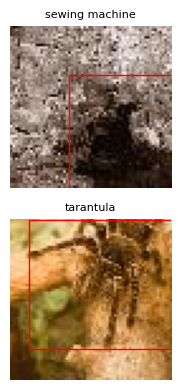

In [9]:
display_images(rsample_images(2))

In [10]:
#display_images(sample_images_by_wnid('n02099601',2))

In [11]:
# Here's how you can create a DataLoader for your dataset. Remember, this code won't run in this environment but you can use it as a template in your local environment:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform for training data
train_transform = transforms.Compose([
    transforms.Pad(4),  # Pad the image by 4 pixels
    transforms.RandomCrop(64),  # Randomly crop a 64x64 region from the padded image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

# Define a transform for validation data
val_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])


# Load Tiny ImageNet dataset
train_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/val', transform=val_transform)



# Create data loaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
len(train_loader)

1000

In [13]:
# Inspect a batch from train_loader
train_images, train_labels = next(iter(train_loader))
print("Train images batch shape:", train_images.shape)
print("Train labels batch shape:", train_labels.shape)
print("Train images data type:", train_images.dtype)
print("Train labels data type:", train_labels.dtype)

# Inspect a batch from val_loader
val_images, val_labels = next(iter(val_loader))
print("Validation images batch shape:", val_images.shape)
print("Validation labels batch shape:", val_labels.shape)
print("Validation images data type:", val_images.dtype)
print("Validation labels data type:", val_labels.dtype)


Train images batch shape: torch.Size([100, 3, 64, 64])
Train labels batch shape: torch.Size([100])
Train images data type: torch.float32
Train labels data type: torch.int64
Validation images batch shape: torch.Size([100, 3, 64, 64])
Validation labels batch shape: torch.Size([100])
Validation images data type: torch.float32
Validation labels data type: torch.int64


In [14]:
def train_model(model, train_loader, batch_size, criterion, optimizer, device, num_epochs):
    model.to(device)
    model.train()  # Set the model to training mode
    total_step = len(train_loader)
    
    for epoch in range(num_epochs):
        loss_list = []
        acc_list = []
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Run the forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Backprop and perform optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            # Uncomment for batch-wise training summaries
            #if (i + 1) % batch_size == 0:
            #    print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Accuracy: {100*(correct / total):.2f}%')

        epoch_loss = np.mean(loss_list)
        epoch_acc = np.mean(acc_list)
        print(f'End of Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {100*epoch_acc:.2f}%')

    # Print the last epoch's average loss and accuracy
    print(f"\nFinal Training accuracy: {100*epoch_acc:.2f}%, Final Training loss: {epoch_loss:.4f}")


In [15]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():  # We don't need gradients for evaluation
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    
    print(f'Final Validation accuracy: {100 * correct / total:.2f}%, Final Validation loss: {total_loss / len(val_loader):.4f}')

### Train CNN's

In [65]:
# Initialize SimpleCNN model and hyperparameters
cnn_model = SimpleCNN()
#cnn_model.load_state_dict(torch.load("./model_params/cnn_model_parameters.pth")) # comment out to train fresh model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10

# Train and then evaulate our model
train_model(cnn_model, train_loader, batch_size, criterion, optimizer, device, num_epochs) # optimizer changed to adam
evaluate_model(cnn_model, val_loader, criterion, device)

# Assume model is your trained model
torch.save(cnn_model.state_dict(), "./model_params/cnn_model_parameters.pth")

End of Epoch [1/10], Loss: 4.2948, Accuracy: 8.39%
End of Epoch [2/10], Loss: 4.2713, Accuracy: 8.61%
End of Epoch [3/10], Loss: 4.2502, Accuracy: 8.83%
End of Epoch [4/10], Loss: 4.2366, Accuracy: 8.96%
End of Epoch [5/10], Loss: 4.2156, Accuracy: 9.18%
End of Epoch [6/10], Loss: 4.2164, Accuracy: 9.18%
End of Epoch [7/10], Loss: 4.1965, Accuracy: 9.41%
End of Epoch [8/10], Loss: 4.1862, Accuracy: 9.44%
End of Epoch [9/10], Loss: 4.1769, Accuracy: 9.72%
End of Epoch [10/10], Loss: 4.1604, Accuracy: 9.72%

Final Training accuracy: 9.72%, Final Training loss: 4.1604
Final Validation accuracy: 11.52%, Final Validation loss: 4.0984


In [34]:
# Initialize SimpleCNN256 model and hyperparameters
cnn_model_256 = SimpleCNN256()
#cnn_model_256.load_state_dict(torch.load("./model_params/cnn_model_256_parameters.pth")) # comment out to train fresh model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_256.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 25

# Train and then evaulate our model
train_model(cnn_model_256, train_loader, batch_size, criterion, optimizer, device, num_epochs) # optimizer changed to adam
evaluate_model(cnn_model_256, val_loader, criterion, device)

# Assume model is your trained model
torch.save(cnn_model_256.state_dict(), "./model_params/cnn_model_256_parameters.pth")

End of Epoch [1/25], Loss: 4.8938, Accuracy: 3.50%
End of Epoch [2/25], Loss: 4.3588, Accuracy: 8.96%
End of Epoch [3/25], Loss: 4.0679, Accuracy: 12.80%
End of Epoch [4/25], Loss: 3.8858, Accuracy: 15.34%
End of Epoch [5/25], Loss: 3.7540, Accuracy: 17.07%
End of Epoch [6/25], Loss: 3.6497, Accuracy: 18.50%
End of Epoch [7/25], Loss: 3.5575, Accuracy: 19.80%
End of Epoch [8/25], Loss: 3.4866, Accuracy: 21.02%
End of Epoch [9/25], Loss: 3.4097, Accuracy: 22.05%
End of Epoch [10/25], Loss: 3.3483, Accuracy: 23.00%
End of Epoch [11/25], Loss: 3.2852, Accuracy: 23.79%
End of Epoch [12/25], Loss: 3.2265, Accuracy: 24.92%
End of Epoch [13/25], Loss: 3.1705, Accuracy: 25.48%
End of Epoch [14/25], Loss: 3.1207, Accuracy: 26.46%
End of Epoch [15/25], Loss: 3.0674, Accuracy: 27.45%
End of Epoch [16/25], Loss: 3.0196, Accuracy: 27.92%
End of Epoch [17/25], Loss: 2.9786, Accuracy: 28.40%
End of Epoch [18/25], Loss: 2.9333, Accuracy: 29.36%
End of Epoch [19/25], Loss: 2.8918, Accuracy: 29.79%
End 

##### CNN Observations:
SimpleCNN's two dense layers are of size 120 and 84 respectively, whereas SimpleCNN256's dense layers are both of size 256.

I tried the model with 512 neurons in each dense layer, but it is overfitting right now. Even with dropout layers, 512 overfits.

The problem persists with 256 neurons too.

### Train ResNet18

In [41]:
# Initialize ResNet18 model and hyperparameters with SGD optimizer
model = ResNet18()
model.load_state_dict(torch.load("./model_params/model_parameters.pth")) # comment out to train fresh model
criterion = nn.CrossEntropyLoss()  # Common choice for of loss for classification problems
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Common choice of optimizer for CNNs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 20

# Train and then evaulate our model
train_model(model, train_loader, batch_size, criterion, optimizer, device, num_epochs)
evaluate_model(model, val_loader, criterion, device)

# Assume model is your trained model
torch.save(model.state_dict(), "./model_params/model_parameters.pth")


End of Epoch [1/20], Loss: 0.6618, Accuracy: 80.50%
End of Epoch [2/20], Loss: 0.6202, Accuracy: 81.63%
End of Epoch [3/20], Loss: 0.5847, Accuracy: 82.52%
End of Epoch [4/20], Loss: 0.5520, Accuracy: 83.38%
End of Epoch [5/20], Loss: 0.5127, Accuracy: 84.52%
End of Epoch [6/20], Loss: 0.4784, Accuracy: 85.56%
End of Epoch [7/20], Loss: 0.4507, Accuracy: 86.19%
End of Epoch [8/20], Loss: 0.4214, Accuracy: 87.07%
End of Epoch [9/20], Loss: 0.4018, Accuracy: 87.62%
End of Epoch [10/20], Loss: 0.3786, Accuracy: 88.29%
End of Epoch [11/20], Loss: 0.3582, Accuracy: 88.78%
End of Epoch [12/20], Loss: 0.3324, Accuracy: 89.62%
End of Epoch [13/20], Loss: 0.3157, Accuracy: 90.13%
End of Epoch [14/20], Loss: 0.2946, Accuracy: 90.71%
End of Epoch [15/20], Loss: 0.2815, Accuracy: 91.16%
End of Epoch [16/20], Loss: 0.2696, Accuracy: 91.53%
End of Epoch [17/20], Loss: 0.2586, Accuracy: 91.92%
End of Epoch [18/20], Loss: 0.2356, Accuracy: 92.60%
End of Epoch [19/20], Loss: 0.2325, Accuracy: 92.64%
En

### Train ResNet34

In [20]:
# Initialize ResNet18 model and hyperparameters with SGD optimizer
model_resnet34 = resnet34()
model_resnet34.load_state_dict(torch.load("./model_params/model_resnet34_parameters.pth")) # comment out to train fresh model
criterion = nn.CrossEntropyLoss()  # Common choice for of loss for classification problems
optimizer = optim.SGD(model_resnet34.parameters(), lr=0.01, momentum=0.9)  # Common choice of optimizer for CNNs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10

# Train and then evaulate our model
train_model(model_resnet34, train_loader, batch_size, criterion, optimizer, device, num_epochs)
evaluate_model(model_resnet34, val_loader, criterion, device)

# Assume model is your trained model
torch.save(model_resnet34.state_dict(), "./model_params/model_resnet34_parameters.pth")

End of Epoch [1/10], Loss: 0.2867, Accuracy: 91.36%
End of Epoch [2/10], Loss: 0.2709, Accuracy: 91.77%
End of Epoch [3/10], Loss: 0.2441, Accuracy: 92.58%
End of Epoch [4/10], Loss: 0.2297, Accuracy: 93.04%
End of Epoch [5/10], Loss: 0.2269, Accuracy: 93.11%
End of Epoch [6/10], Loss: 0.2105, Accuracy: 93.53%
End of Epoch [7/10], Loss: 0.1886, Accuracy: 94.19%
End of Epoch [8/10], Loss: 0.1759, Accuracy: 94.68%
End of Epoch [9/10], Loss: 0.1841, Accuracy: 94.47%
End of Epoch [10/10], Loss: 0.1596, Accuracy: 95.12%

Final Training accuracy: 95.12%, Final Training loss: 0.1596
Final Validation accuracy: 57.45%, Final Validation loss: 2.7633


### To-Do List:
- Add dropout layers to our models to work on overfitting issue! DONE
- Add data augmentation in the training transform to work on overfitting issue! DONE
    - From the previous two changes, val accuracy is up from 40% to 57%

- Both Resnet models are now reaching ~57% val accuracy while reaching ~95% training accuracy
    - Model is overfitting, but still performing better after data augmentation

 - Remove dropout layers and test models with only data augmentation!